In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from sklearn.metrics import mean_squared_log_error
import cv2

# Data

In [2]:
# Définir le chemin du dossier contenant les fichiers x_train et y_train
x_train_folder = "x_train"
y_train_data = pd.read_csv("y_train.csv")

## Fonction

In [3]:
def load_data_and_labels(start_index, end_index, x_train_folder, y_train_data):
    """
    Charge les données et les étiquettes d'entraînement depuis les fichiers .npz et un fichier CSV
    dans l'intervalle spécifié.

    Args:
    - start_index (int): L'index de début pour charger les données (inclu).
    - end_index (int): L'index de fin pour charger les données (exclu).
    - x_train_folder (str): Le chemin du dossier contenant les fichiers x_train (.npz).
    - y_train_path (str): Le chemin vers le fichier y_train.csv contenant les étiquettes.

    Returns:
    - Tuple de numpy arrays: (data_array, labels_array) contenant les données et les étiquettes chargées.
    """
    # Initialiser les listes pour stocker les données et les étiquettes
    speeds_list = []
    data_list = []
    labels_list = []
    optical_flow_magnitude_list = []
    optical_flow_angle_list = []

    # Boucle sur les fichiers .npz dans l'intervalle spécifié
    for id_img in tqdm(range(start_index, end_index), desc="Chargement des données"):
        sample_x_train_file = os.path.join(x_train_folder, f"{id_img}.npz")
        if os.path.exists(sample_x_train_file):  # Vérifier si le fichier existe
            sample_x_train_data = np.load(sample_x_train_file)
            x_train_data = sample_x_train_data['data']

            # Ajouter les données à la liste
            data_list.append(x_train_data)

            temp_speeds_list = []

            # Initialiser des listes temporaires pour stocker la magnitude et l'angle du flux optique
            # Ajouter un élément de flux optique nul au début de chaque liste
            zero_flow_magnitude = np.zeros((128, 128))
            zero_flow_angle = np.zeros((128, 128))
            temp_magnitude_list = [zero_flow_magnitude]
            temp_angle_list = [zero_flow_angle]
            
            for i in range(len(x_train_data) - 1):

                # Calculer la différence absolue entre les images successives
                speed = np.abs(x_train_data[i+1] - x_train_data[i])
                
                # Ajouter la "vitesse" calculée à la liste temporaire
                temp_speeds_list.append(speed)

                # Calculer le flux optique entre les images successives
                flow = cv2.calcOpticalFlowFarneback(x_train_data[i], x_train_data[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
                
                # Calculer la magnitude et l'angle du flux optique
                magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                temp_magnitude_list.append(magnitude)
                temp_angle_list.append(angle)
    
            # S'il y a moins de 3 vitesses calculées, on remplit avec des zéros pour garder une dimension constante
            while len(temp_speeds_list) < 3:
                temp_speeds_list.append(np.zeros_like(x_train_data[0]))
            
            # Ajouter les vitesses calculées à la liste principale
            speeds_list.append(np.array(temp_speeds_list))

            # Ajouter les magnitudes et angles calculés à leurs listes respectives
            optical_flow_magnitude_list.append(np.array(temp_magnitude_list))
            optical_flow_angle_list.append(np.array(temp_angle_list))

            # Calculer l'index de début pour les étiquettes correspondantes
            label_start_index = id_img * 8
            # Charger les étiquettes correspondantes depuis le fichier CSV
            y_train_labels = y_train_data[label_start_index: label_start_index + 8]['TARGET'].values
            labels_list.append(y_train_labels)
        else:
            print(f"Fichier {id_img}.npz introuvable.")

    # Convertir les listes en tableaux numpy pour une utilisation avec le CNN
    data_array = np.array(data_list)
    optical_flow_magnitude_array = np.array(optical_flow_magnitude_list)
    optical_flow_angle_array = np.array(optical_flow_angle_list)
    labels_array = np.array(labels_list)
    speeds_array = np.array(speeds_list)

    print(f"Data array shape: {data_array.shape}")
    print(f"Optical flow magnitude array shape: {optical_flow_magnitude_array.shape}")
    print(f"Optical flow angle array shape: {optical_flow_angle_array.shape}")
    print(f"Labels array shape: {labels_array.shape}")
    print(f"Speeds array shape: {speeds_array.shape}")

    return data_array, labels_array, optical_flow_magnitude_array, optical_flow_angle_array, speeds_array

## Suite

In [4]:
# Définir les indices de début et de fin pour les images à charger
start_index = 60000 # Inclure cette valeur
end_index = 62500 # Exclure cette valeur


In [5]:
data_array, labels_array, optical_flow_magnitude_array, optical_flow_angle_array, speeds_array = load_data_and_labels(start_index, end_index, x_train_folder, y_train_data)

Chargement des données: 100%|██████████| 2500/2500 [00:41<00:00, 60.37it/s]


Data array shape: (2500, 4, 128, 128)
Optical flow magnitude array shape: (2500, 4, 128, 128)
Optical flow angle array shape: (2500, 4, 128, 128)
Labels array shape: (2500, 8)
Speeds array shape: (2500, 3, 128, 128)


In [6]:
# proportion de 0 dans le data_array
print(f"Proportion de 0 dans le data_array: {np.count_nonzero(data_array == 0) / data_array.size}")

Proportion de 0 dans le data_array: 0.7973903015136719


In [7]:
data_log = np.log(data_array+1)  # Appliquer le logarithme pour normaliser les données
y_log = np.log(labels_array+1)  # Appliquer le logarithme pour normaliser les étiquettes
optical_flow_angle_log = np.log(optical_flow_angle_array+1)  # Appliquer le logarithme pour normaliser les données
optical_flow_magnitude_log = np.log(optical_flow_magnitude_array+1)  # Appliquer le logarithme pour normaliser les données
speeds_log = np.log(speeds_array+1)  # Appliquer le logarithme pour normaliser les données
#data_log_reshaped = data_log.reshape(-1, 128, 128, 4)  # Remodelage important ici

In [8]:
#Reshape pour avoir les canaux en dernier
data_reshaped = data_log.reshape(-1, 128, 128, 4)  # Maintenant de forme (N, 128, 128, 4)
X_3D = data_reshaped.reshape(-1, 4, 128, 128, 1)
speeds_reshaped = speeds_log.reshape(-1, 128, 128, 3)  # Maintenant de forme (N, 128, 128, 3)

#Concaténation le long de l'axe des canaux
X_speeds = np.concatenate([data_reshaped, speeds_reshaped], axis=-1)  # De forme (N, 128, 128, 7)

In [36]:
# print shape de notre data_array et X_3D

print(f"Shape de X: {data_array.shape}")
print(f"Shape de X_reshaped: {data_reshaped.shape}")
print(f"Shape de X_3D: {X_3D.shape}")


Shape de X: (2500, 4, 128, 128)
Shape de X_reshaped: (2500, 128, 128, 4)
Shape de X_3D: (2500, 4, 128, 128, 1)


In [9]:
#Concaténer les données d'images avec les données de flux optique (magnitude et angle)
data_cnn_ready = np.concatenate([data_log, optical_flow_magnitude_log, optical_flow_angle_array], axis=-1)
data_cnn_reshaped = data_cnn_ready.reshape(-1, 128, 128, 12)  # Ajustez selon le nombre réel de canaux

X_test = data_cnn_reshaped
y_test = y_log

#Vérifier les dimensions des ensembles d'entraînement et de test
print("Forme de X_train:", X_test.shape)
print("Forme de X_test:", y_test.shape)


Forme de X_train: (2500, 128, 128, 12)
Forme de X_test: (2500, 8)


In [10]:
#Identifier les éléments infinis
infinite_mask_test = np.isinf(X_test)

max_value_test = np.max(X_test[~infinite_mask_test])
X_test[infinite_mask_test] = max_value_test

In [11]:
#crée un data frame qui comprend les valeurs max et moyennes de X_train, X_test, y_train et y_test
df = pd.DataFrame({'max': [X_test.max(), y_log.max(), ],
                   'min': [X_test.min(), y_log.min()],
                   'mean': [X_test.mean(), y_log.mean()]},
                   
                  index=['X', 'Y'])
df

,max,min,mean
X,8.078378,0.0,0.864552
Y,6.656727,0.0,0.571153


# Importation des models

In [12]:
# Chargement du modèle sauvegardé au format .keras

# entrainement 50k fichiers
model_b16_e10 = load_model(r'modeles\mon_modele_b16_e10.h5')
model_b32_e10 = load_model(r'modeles\mon_modele_b32_e10.h5')
model_b16_e20 = load_model(r'modeles\mon_modele_b16_e20.h5')
model_b32_e20 = load_model(r'modeles\mon_modele_b32_e20.h5')

# entrainement 10k fichiers
model_L_cnn = load_model(r'modeles\L_cnn_10k.h5')

model_7C_L_cnn_best_b16_e10 = load_model(r'modeles\L_cnn_7c_10k_best_b16_e10.h5')
model_7C_L_cnn_best_b32_e10 = load_model(r'modeles\L_cnn_7c_10k_best_b32_e10.h5')
model_7C_L_cnn_best_b16_e20 = load_model(r'modeles\L_cnn_7c_10k_best_b16_e20.h5')
model_7C_L_cnn_best_b32_e20 = load_model(r'modeles\L_cnn_7c_10k_best_b32_e20.h5')

model_7C_L_cnn_best_b16_e10_relu = load_model(r'modeles\L_cnn_7c_10k_best_b16_e10_relu.h5')

# entrainement 50k fichiers
model_3D_b32_e10_500 = load_model(r'modeles\modele3D_b32_e10_rmsprop_500.h5')
model_3D_best_50k = load_model(r'modeles\modele3D_best_50k.h5')


# Evaluation des modeles

In [13]:
x_test_log = X_test
y_test_log = y_log
data_log = data_log.reshape(-1, 128, 128, 4)  # Remodelage important ici

In [14]:
# Supposons que `x_test` et `y_test` sont vos données et étiquettes de test
eval_b16_e10 = model_b16_e10.evaluate(data_log, y_test_log)
eval_b32_e10 = model_b32_e10.evaluate(data_log, y_test_log)
eval_b16_e20 = model_b16_e20.evaluate(data_log, y_test_log)
eval_b32_e20 = model_b32_e20.evaluate(data_log, y_test_log)

print("Évaluation modèle b16 e10:", eval_b16_e10)
print("Évaluation modèle b32 e10:", eval_b32_e10)
print("Évaluation modèle b16 e20:", eval_b16_e20)
print("Évaluation modèle b32 e20:", eval_b32_e20)


79/79 [==============================] - 7s 91ms/step - loss: 0.1297 - mse: 0.1297
Évaluation modèle b16 e10: [0.15933582186698914, 0.15933582186698914]
Évaluation modèle b32 e10: [0.43568089604377747, 0.43568089604377747]
Évaluation modèle b16 e20: [0.22808454930782318, 0.22808454930782318]
Évaluation modèle b32 e20: [0.12967449426651, 0.12967449426651]


In [15]:
eval_L_cnn = model_L_cnn.evaluate(x_test_log, y_test_log)

eval_L_cnn_7c_best_b16_e10 = model_7C_L_cnn_best_b16_e10.evaluate(X_speeds, y_test_log)
eval_L_cnn_7c_best_b32_e10 = model_7C_L_cnn_best_b32_e10.evaluate(X_speeds, y_test_log)
eval_L_cnn_7c_best_b16_e20 = model_7C_L_cnn_best_b16_e20.evaluate(X_speeds, y_test_log)
eval_L_cnn_7c_best_b32_e20 = model_7C_L_cnn_best_b32_e20.evaluate(X_speeds, y_test_log)

eval_L_cnn_7c_best_b16_e10_relu = model_7C_L_cnn_best_b16_e10_relu.evaluate(X_speeds, y_test_log)


print("Évaluation modèle L_cnn:", eval_L_cnn)

print("Évaluation modèle 7canaux L_cnn best b16 e10:", eval_L_cnn_7c_best_b16_e10)
print("Évaluation modèle 7canaux L_cnn best b32 e10:", eval_L_cnn_7c_best_b32_e10)
print("Évaluation modèle 7canaux L_cnn best b16 e20:", eval_L_cnn_7c_best_b16_e20)
print("Évaluation modèle 7canaux L_cnn best b32 e20:", eval_L_cnn_7c_best_b32_e20)

print("Évaluation modèle 7canaux L_cnn best b16 e10 relu:", eval_L_cnn_7c_best_b16_e10_relu)

79/79 [==============================] - 8s 103ms/step - loss: 0.2901 - mse: 0.2901
Évaluation modèle L_cnn: [0.3257678747177124, 0.3257678747177124]
Évaluation modèle 7canaux L_cnn best b16 e10: [0.25842949748039246, 0.25842949748039246]
Évaluation modèle 7canaux L_cnn best b32 e10: [0.34111106395721436, 0.34111106395721436]
Évaluation modèle 7canaux L_cnn best b16 e20: [0.2604368031024933, 0.2604368031024933]
Évaluation modèle 7canaux L_cnn best b32 e20: [0.26828429102897644, 0.26828429102897644]
Évaluation modèle 7canaux L_cnn best b16 e10 relu: [0.2900858223438263, 0.2900858223438263]


In [16]:
eval_3D_500 = model_3D_b32_e10_500.evaluate(X_3D, y_test_log)
eval_3D_50k = model_3D_best_50k.evaluate(X_3D, y_test_log)

print("Évaluation modèle 3D 500:", eval_3D_500)
print("Évaluation modèle 3D 50k:", eval_3D_50k)

79/79 [==============================] - 76s 962ms/step - loss: 0.1387 - mse: 0.1387
Évaluation modèle 3D 500: [0.5460860133171082, 0.5460860133171082]
Évaluation modèle 3D 50k: [0.13869377970695496, 0.13869377970695496]


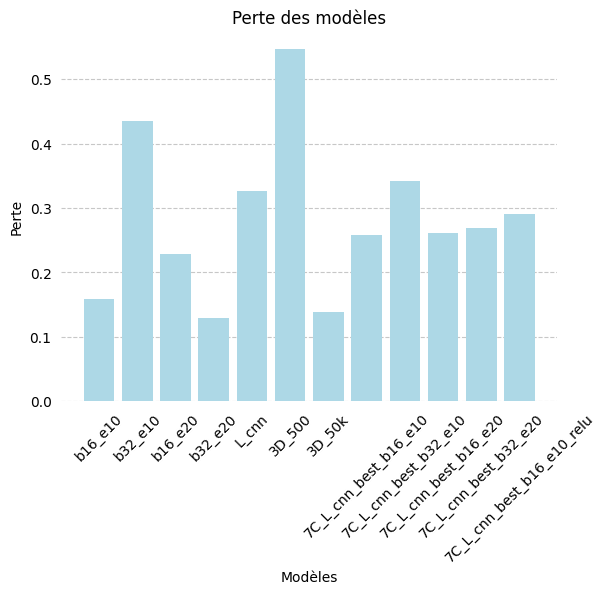

In [17]:
# graphique pour comparer les modèles
import matplotlib.pyplot as plt

# Définir les noms des modèles et les scores
model_names = ['b16_e10', 'b32_e10', 'b16_e20', 'b32_e20', 'L_cnn', '3D_500', '3D_50k', '7C_L_cnn_best_b16_e10', '7C_L_cnn_best_b32_e10', '7C_L_cnn_best_b16_e20', '7C_L_cnn_best_b32_e20', '7C_L_cnn_best_b16_e10_relu']
model_scores = [eval_b16_e10[0], eval_b32_e10[0], eval_b16_e20[0], eval_b32_e20[0], eval_L_cnn[0], eval_3D_500[0], eval_3D_50k[0], eval_L_cnn_7c_best_b16_e10[0], eval_L_cnn_7c_best_b32_e10[0], eval_L_cnn_7c_best_b16_e20[0], eval_L_cnn_7c_best_b32_e20[0], eval_L_cnn_7c_best_b16_e10_relu[0]]


# Créer un graphique à barres pour comparer les modèles, mettre en évidence le meilleur modèle
fig, ax = plt.subplots()
ax.bar(model_names, model_scores, color='lightblue')
ax.set_xlabel('Modèles')
ax.set_ylabel('Perte')
ax.set_title('Perte des modèles')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.xticks(rotation=45)
plt.show()

# Predictions du modele

In [18]:
# normalisation log de x_test
#x_test_log = np.log(x_test+1)  # Appliquer le logarithme pour normaliser les données

y_pred_b16_e10 = model_b16_e10.predict(data_log)
y_pred_b32_e10 = model_b32_e10.predict(data_log)
y_pred_b16_e20 = model_b16_e20.predict(data_log)
y_pred_b32_e20 = model_b32_e20.predict(data_log)
y_pred_L_cnn = model_L_cnn.predict(x_test_log)
y_pred_3D_500 = model_3D_b32_e10_500.predict(X_3D)
y_pred_3D_50k = model_3D_best_50k.predict(X_3D)
y_pred_7C_L_cnn_best_b16_e10 = model_7C_L_cnn_best_b16_e10.predict(X_speeds)
y_pred_7C_L_cnn_best_b32_e10 = model_7C_L_cnn_best_b32_e10.predict(X_speeds)
y_pred_7C_L_cnn_best_b16_e20 = model_7C_L_cnn_best_b16_e20.predict(X_speeds)
y_pred_7C_L_cnn_best_b32_e20 = model_7C_L_cnn_best_b32_e20.predict(X_speeds)
y_pred_7C_L_cnn_best_b16_e10_relu = model_7C_L_cnn_best_b16_e10_relu.predict(X_speeds)


79/79 [==============================] - 8s 105ms/step


In [19]:
# enlever normalisation log des prédictions
y_pred_b16_e10 = np.exp(y_pred_b16_e10) - 1
y_pred_b32_e10 = np.exp(y_pred_b32_e10) - 1
y_pred_b16_e20 = np.exp(y_pred_b16_e20) - 1
y_pred_b32_e20 = np.exp(y_pred_b32_e20) - 1
y_pred_L_cnn = np.exp(y_pred_L_cnn) - 1
y_pred_3D_500 = np.exp(y_pred_3D_500) - 1
y_pred_3D_50k = np.exp(y_pred_3D_50k) - 1
y_pred_7C_L_cnn_best_b16_e10 = np.exp(y_pred_7C_L_cnn_best_b16_e10) - 1
y_pred_7C_L_cnn_best_b32_e10 = np.exp(y_pred_7C_L_cnn_best_b32_e10) - 1
y_pred_7C_L_cnn_best_b16_e20 = np.exp(y_pred_7C_L_cnn_best_b16_e20) - 1
y_pred_7C_L_cnn_best_b32_e20 = np.exp(y_pred_7C_L_cnn_best_b32_e20) - 1
y_pred_7C_L_cnn_best_b16_e10_relu = np.exp(y_pred_7C_L_cnn_best_b16_e10_relu) - 1



In [20]:
y_test = np.exp(y_test) - 1  # Enlever la normalisation log des étiquettes

In [21]:
log_mse_b16_e10 = mean_squared_log_error(y_test, np.abs(y_pred_b16_e10))
log_mse_b32_e10 = mean_squared_log_error(y_test, np.abs(y_pred_b32_e10))
log_mse_b16_e20 = mean_squared_log_error(y_test, np.abs(y_pred_b16_e20))
log_mse_b32_e20 = mean_squared_log_error(y_test, np.abs(y_pred_b32_e20))
log_mse_L_cnn = mean_squared_log_error(y_test, np.abs(y_pred_L_cnn))
log_mse_3D_500 = mean_squared_log_error(y_test, np.abs(y_pred_3D_500))
log_mse_3D_50k = mean_squared_log_error(y_test, np.abs(y_pred_3D_50k))
log_mse_7C_L_cnn_best_b16_e10 = mean_squared_log_error(y_test, np.abs(y_pred_7C_L_cnn_best_b16_e10))
log_mse_7C_L_cnn_best_b32_e10 = mean_squared_log_error(y_test, np.abs(y_pred_7C_L_cnn_best_b32_e10))
log_mse_7C_L_cnn_best_b16_e20 = mean_squared_log_error(y_test, np.abs(y_pred_7C_L_cnn_best_b16_e20))
log_mse_7C_L_cnn_best_b32_e20 = mean_squared_log_error(y_test, np.abs(y_pred_7C_L_cnn_best_b32_e20))
log_mse_7C_L_cnn_best_b16_e10_relu = mean_squared_log_error(y_test, np.abs(y_pred_7C_L_cnn_best_b16_e10_relu))


print("Log-MSE modèle b16 e10:", log_mse_b16_e10)
print("Log-MSE modèle b32 e10:", log_mse_b32_e10)
print("Log-MSE modèle b16 e20:", log_mse_b16_e20)
print("Log-MSE modèle b32 e20:", log_mse_b32_e20)
print("Log-MSE modèle L_cnn:", log_mse_L_cnn)
print("Log-MSE modèle 3D_500:", log_mse_3D_500)
print("Log-MSE modèle 3D_50k:", log_mse_3D_50k)
print("Log-MSE modèle 7C_L_cnn_best_b16_e10:", log_mse_7C_L_cnn_best_b16_e10)
print("Log-MSE modèle 7C_L_cnn_best_b32_e10:", log_mse_7C_L_cnn_best_b32_e10)
print("Log-MSE modèle 7C_L_cnn_best_b16_e20:", log_mse_7C_L_cnn_best_b16_e20)
print("Log-MSE modèle 7C_L_cnn_best_b32_e20:", log_mse_7C_L_cnn_best_b32_e20)
print("Log-MSE modèle 7C_L_cnn_best_b16_e10_relu:", log_mse_7C_L_cnn_best_b16_e10_relu)


Log-MSE modèle b16 e10: 0.15886402994775095
Log-MSE modèle b32 e10: 0.435415497281714
Log-MSE modèle b16 e20: 0.22790007757972963
Log-MSE modèle b32 e20: 0.1292937545370077
Log-MSE modèle L_cnn: 0.32381860405770846
Log-MSE modèle 3D_500: 0.5460859302457264
Log-MSE modèle 3D_50k: 0.13768154381479716
Log-MSE modèle 7C_L_cnn_best_b16_e10: 0.2523576769608026
Log-MSE modèle 7C_L_cnn_best_b32_e10: 0.33108711215741926
Log-MSE modèle 7C_L_cnn_best_b16_e20: 0.25715828891188297
Log-MSE modèle 7C_L_cnn_best_b32_e20: 0.26579182878023666
Log-MSE modèle 7C_L_cnn_best_b16_e10_relu: 0.2900857846986342


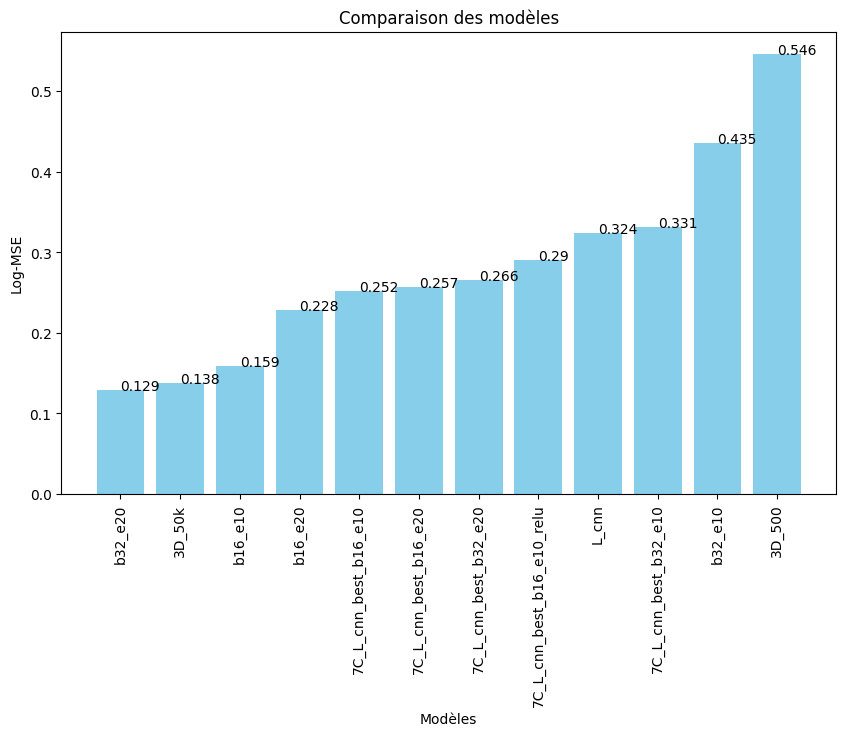

In [22]:
# Définir les noms des modèles et les scores
model_names = ['b16_e10', 'b32_e10', 'b16_e20', 'b32_e20', 'L_cnn', '3D_500', '3D_50k', '7C_L_cnn_best_b16_e10', '7C_L_cnn_best_b32_e10', '7C_L_cnn_best_b16_e20', '7C_L_cnn_best_b32_e20', '7C_L_cnn_best_b16_e10_relu']
model_scores = [log_mse_b16_e10, log_mse_b32_e10, log_mse_b16_e20, log_mse_b32_e20, log_mse_L_cnn, log_mse_3D_500, log_mse_3D_50k, log_mse_7C_L_cnn_best_b16_e10, log_mse_7C_L_cnn_best_b32_e10, log_mse_7C_L_cnn_best_b16_e20, log_mse_7C_L_cnn_best_b32_e20, log_mse_7C_L_cnn_best_b16_e10_relu]

#ordonne par orde croissant model_scores en gardant le model_names correspondant
model_names = [x for _, x in sorted(zip(model_scores, model_names))]
model_scores.sort()

# Créer un graphique à barres pour comparer les modèles
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_scores, color='skyblue')
# xlabel en vertical
plt.xticks(rotation=90)
plt.xlabel('Modèles')
plt.ylabel('Log-MSE')
plt.title('Comparaison des modèles')

#afficher valeurs sur les barres
for index, value in enumerate(model_scores):
    plt.text(index, value, str(round(value, 3)))

plt.show()


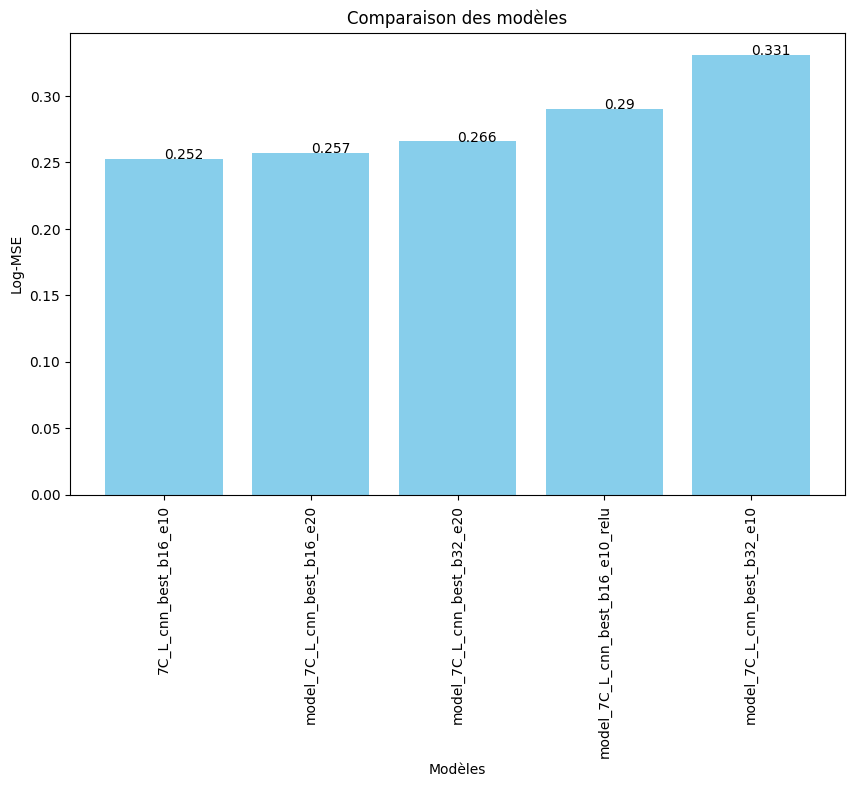

In [35]:
# Définir les noms des modèles et les scores
model_names = ['7C_L_cnn_best_b16_e10', 'model_7C_L_cnn_best_b16_e20', 'model_7C_L_cnn_best_b32_e10', 'model_7C_L_cnn_best_b32_e20', 'model_7C_L_cnn_best_b16_e10_relu']
model_scores = [log_mse_7C_L_cnn_best_b16_e10, log_mse_7C_L_cnn_best_b16_e20, log_mse_7C_L_cnn_best_b32_e10, log_mse_7C_L_cnn_best_b32_e20, log_mse_7C_L_cnn_best_b16_e10_relu]

#ordonne par orde croissant model_scores en gardant le model_names correspondant
model_names = [x for _, x in sorted(zip(model_scores, model_names))]
model_scores.sort()

# Créer un graphique à barres pour comparer les modèles
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_scores, color='skyblue')
# xlabel en vertical
plt.xticks(rotation=90)
plt.xlabel('Modèles')
plt.ylabel('Log-MSE')
plt.title('Comparaison des modèles')

#afficher valeurs sur les barres
for index, value in enumerate(model_scores):
    plt.text(index, value, str(round(value, 3)))

plt.show()


In [31]:
#crée un data frame qui comprend les valeurs max et moyennes de X_train, X_test, y_train et y_test
df = pd.DataFrame({'max': [y_test.max(), y_pred_b16_e10.max(), y_pred_b32_e10.max(), y_pred_b16_e20.max(), y_pred_b32_e20.max(), y_pred_L_cnn.max(), y_pred_3D_500.max(), y_pred_3D_50k.max(),y_pred_7C_L_cnn_best_b16_e10.max(), y_pred_7C_L_cnn_best_b16_e20.max(), y_pred_7C_L_cnn_best_b32_e10.max(), y_pred_7C_L_cnn_best_b32_e20.max(), y_pred_7C_L_cnn_best_b16_e10_relu.max()],
                   'min': [y_test.min(), y_pred_b16_e10.min(), y_pred_b32_e10.min(), y_pred_b16_e20.min(), y_pred_b32_e20.min(), y_pred_L_cnn.min(), y_pred_3D_500.min(), y_pred_3D_50k.min(),y_pred_7C_L_cnn_best_b16_e10.min(), y_pred_7C_L_cnn_best_b16_e20.min(), y_pred_7C_L_cnn_best_b32_e10.min(), y_pred_7C_L_cnn_best_b32_e20.min(), y_pred_7C_L_cnn_best_b16_e10_relu.min()],
                   'mean': [y_test.mean(), y_pred_b16_e10.mean(), y_pred_b32_e10.mean(), y_pred_b16_e20.mean(), y_pred_b32_e20.mean(), y_pred_L_cnn.mean(), y_pred_3D_500.mean(), y_pred_3D_50k.mean(),y_pred_7C_L_cnn_best_b16_e10.mean(), y_pred_7C_L_cnn_best_b16_e20.mean(), y_pred_7C_L_cnn_best_b32_e10.mean(), y_pred_7C_L_cnn_best_b32_e20.mean(), y_pred_7C_L_cnn_best_b16_e10_relu.mean()]},
                   
                  index=['Y', 'Y_pred_b16_e10', 'Y_pred_b32_e10', 'Y_pred_b16_e20', 'Y_pred_b32_e20', 'Y_pred_L_cnn','Y_pred_3D_500', 'Y_pred_3D_50k', 'y_pred_7C_L_cnn_best_b16_e10', 'y_pred_7C_L_cnn_best_b16_e20', 'y_pred_7C_L_cnn_best_b32_e10','y_pred_7C_L_cnn_best_b32_e20', 'y_pred_7C_L_cnn_best_b16_e10_relu'])
df

,max,min,mean
Y,7.770000e+02,0.000000,5.555050e+00
Y_pred_b16_e10,4.890680e+04,-0.553836,9.521136e+00
Y_pred_b32_e10,2.298247e+13,-0.569760,1.229009e+09
Y_pred_b16_e20,1.158643e+06,-0.509100,2.047845e+02
Y_pred_b32_e20,7.244412e+02,-0.615600,5.341000e+00
Y_pred_L_cnn,3.267945e+04,-0.465690,8.613556e+00
Y_pred_3D_500,1.138048e+02,-0.084378,1.874717e+00
Y_pred_3D_50k,1.462468e+03,-0.616901,3.579393e+00
y_pred_7C_L_cnn_best_b16_e10,6.774396e+02,-0.601954,3.710590e+00
y_pred_7C_L_cnn_best_b16_e20,4.213803e+02,-0.549375,3.225485e+00


In [33]:
#afficher ces lignes : ['Y_test','Y_pred_b32_20','Y_pred_3D_50k','Y_pred_L_cnn','y_pred_7C_L_cnn_best_b16_e10'] du df
df.loc[['Y', 'Y_pred_b32_e20', 'Y_pred_3D_50k', 'Y_pred_L_cnn', 'y_pred_7C_L_cnn_best_b16_e10']]

,max,min,mean
Y,777.000000,0.000000,5.555050
Y_pred_b32_e20,724.441223,-0.615600,5.341000
Y_pred_3D_50k,1462.467896,-0.616901,3.579393
Y_pred_L_cnn,32679.447266,-0.465690,8.613556
y_pred_7C_L_cnn_best_b16_e10,677.439575,-0.601954,3.710590


In [34]:
# Faire des prédictions sur l'ensemble de test
#predicted_precipitations = y_pred_b32_e20
predicted_precipitations = y_pred_b32_e20

# Afficher les prédictions pour les premiers échantillons
for i in range(5):  # Afficher les 5 premiers échantillons
    print(f"Echantillon {i}:")
    print("Prédictions :", predicted_precipitations[i])
    print("Valeurs réelles :", y_test[i])
    print()


Echantillon 0:
Prédictions : [70.570244  59.72348   42.795685  24.70245   14.330467   8.532881
  5.433725   2.8886716]
Valeurs réelles : [80. 80. 18. 18. 18. 18. 18.  1.]

Echantillon 1:
Prédictions : [0.24126792 0.2373184  0.17922771 0.15274191 0.11838579 0.13033128
 0.1262368  0.16251945]
Valeurs réelles : [0. 0. 0. 0. 0. 0. 0. 0.]

Echantillon 2:
Prédictions : [7.507077 7.870902 8.659358 9.053669 9.821349 9.688657 9.348973 8.089076]
Valeurs réelles : [ 8.  8.  8.  8. 15. 15. 15. 15.]

Echantillon 3:
Prédictions : [-0.01798218 -0.00262231 -0.02476889 -0.00220627  0.00702047  0.07033968
  0.1089623   0.21431077]
Valeurs réelles : [0. 0. 0. 0. 0. 0. 0. 0.]

Echantillon 4:
Prédictions : [10.0517025   7.8649435   4.868389    2.372875    0.8636968   0.19922018
 -0.15609485 -0.3998565 ]
Valeurs réelles : [27. 27.  2.  2.  2.  0.  0.  0.]



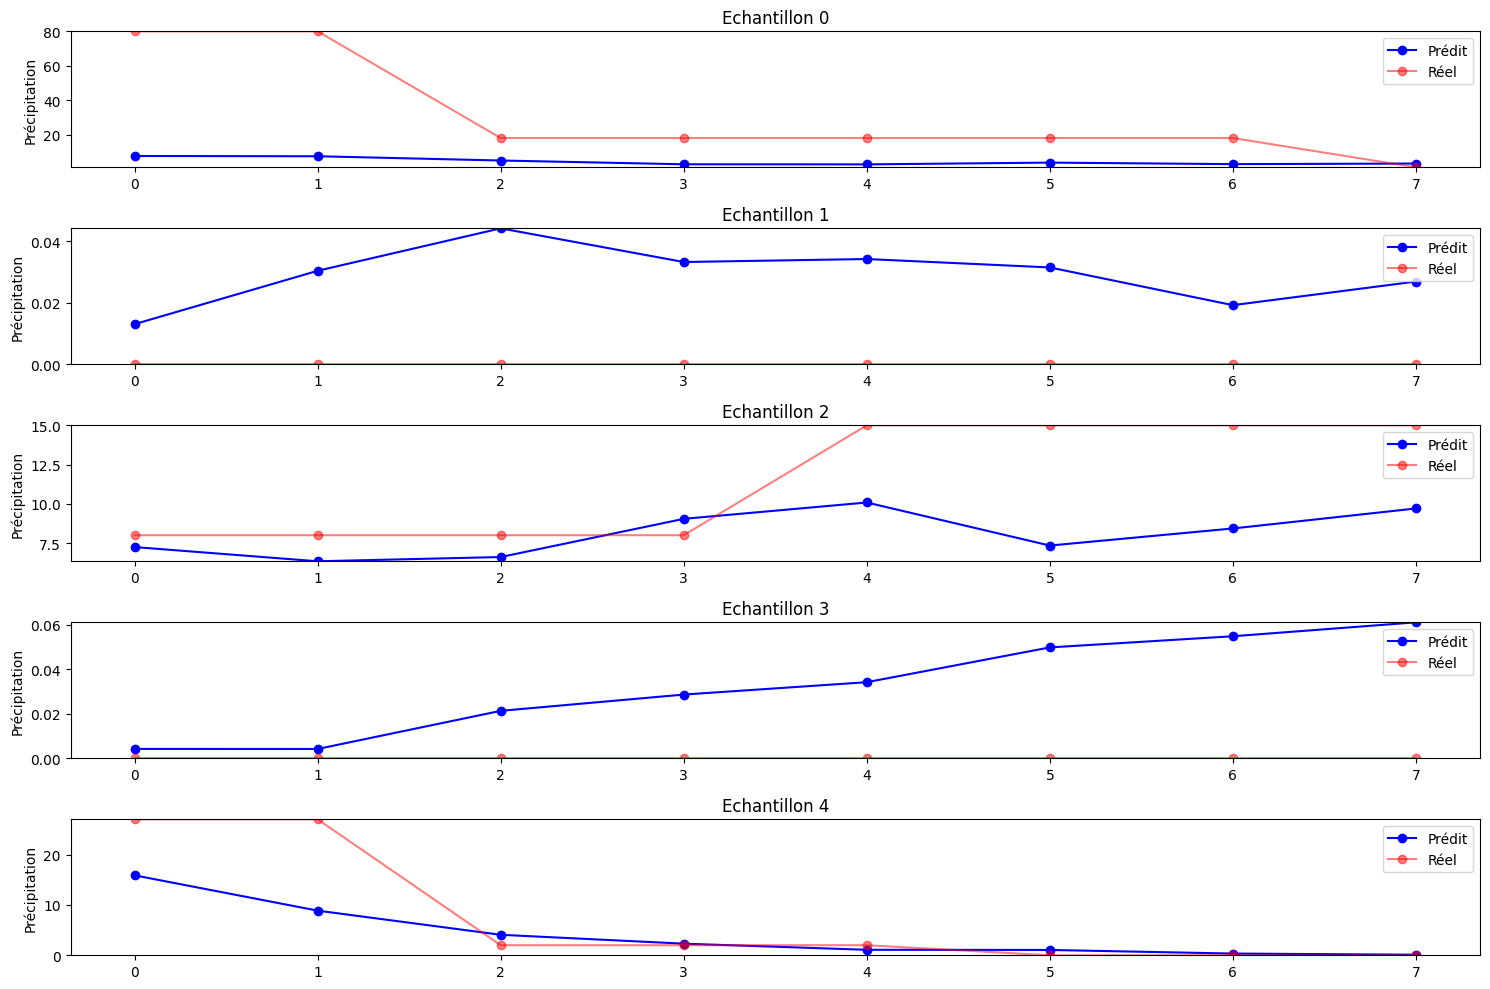

In [26]:
# Choisissez un nombre d'échantillons à visualiser
num_samples_to_display = 5

# Créer des graphiques pour les premiers échantillons
plt.figure(figsize=(15, 10))

for i in range(num_samples_to_display):
    plt.subplot(num_samples_to_display, 1, i + 1)

    # Trouver les valeurs min et max pour l'échantillon actuel
    y_values = np.concatenate((predicted_precipitations[i], y_test[i]))
    y_min, y_max = y_values.min(), y_values.max()

    plt.plot(predicted_precipitations[i], label='Prédit', marker='o', linestyle='-', color='b')
    plt.plot(range(len(y_test[i])), y_test[i], alpha=0.5, label='Réel', marker='o', linestyle='-', color='r')
    plt.title(f'Echantillon {i}')
    plt.ylabel('Précipitation')
    plt.ylim(y_min, y_max)  # Appliquer les limites spécifiques à cet échantillon
    plt.legend()

plt.tight_layout()
plt.show()
